In [1]:
import pandas as pd
voice2 = pd.read_csv('Voice2.csv')

#normalise 
from sklearn import preprocessing
import numpy as np

X_columns = ['Jitter (local, absolute)', 'Jitter (rap)', 'Jitter (ppq5)',
       'Jitter (ddp)', 'Shimmer (local)', 'Shimmer (local,dB)',
       'Shimmer (apq3)', 'Shimmer (apq5)', 'Shimmer (apq11)', 'Shimmer (dda)',
       'Noise to harmonics', 'Harmonics to noise']
# based on heat correlation map ref SVR 
# shimmer(local,dB) -0.22, shimmer(local) -0.16, shimmer(apq11) -0.15
# jitter(rap) -0.13, jitter(ddp) -0.13

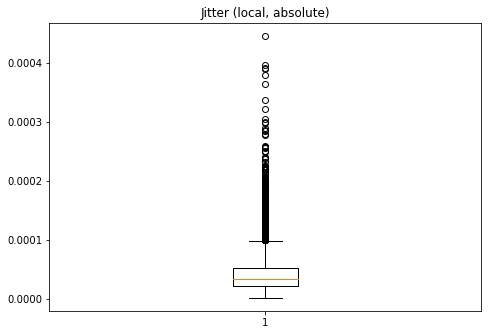

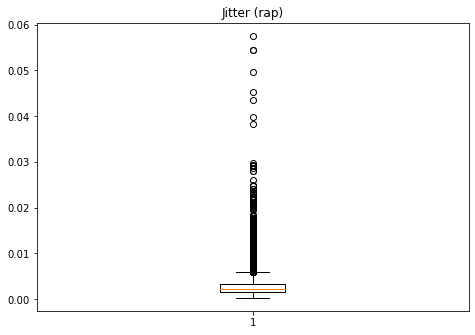

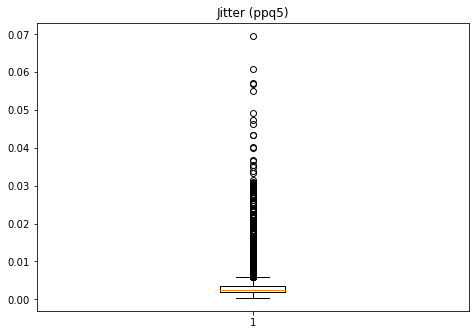

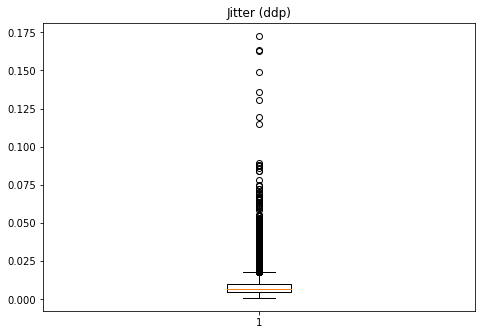

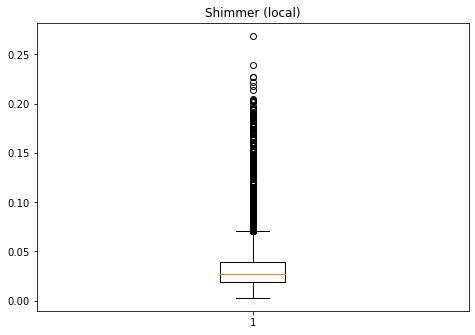

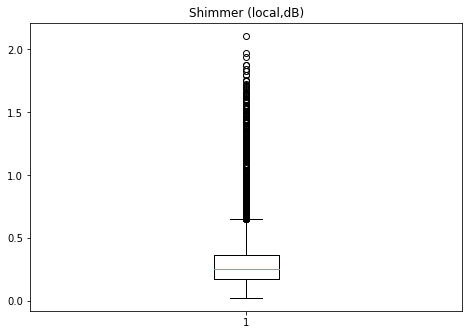

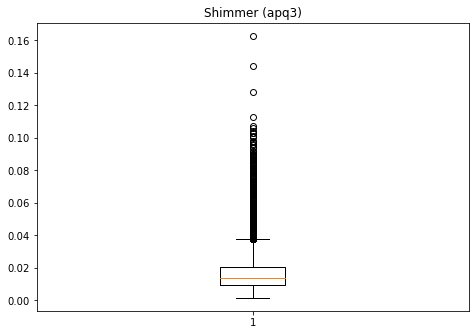

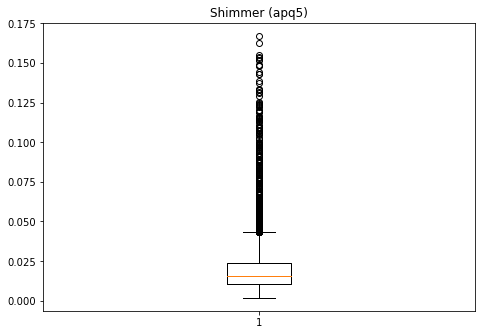

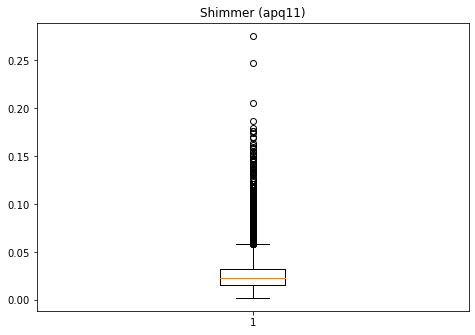

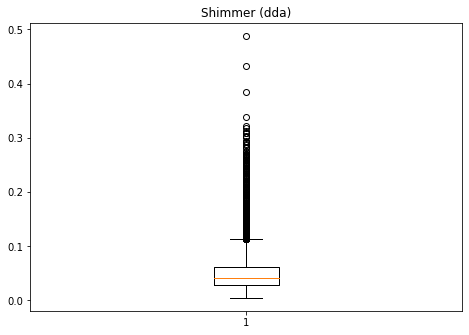

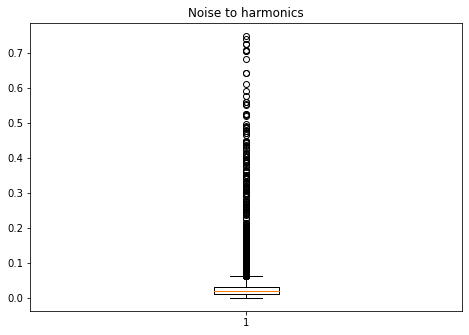

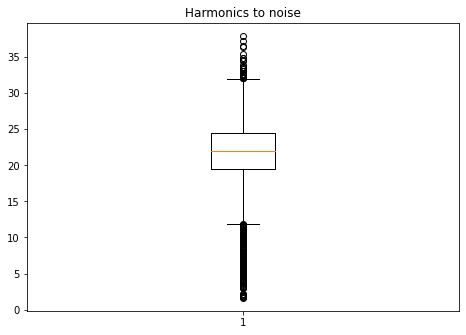

In [2]:
# Data visualization
import matplotlib.pyplot as plt

for col in X_columns:
    data = voice2[col]
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data)
    plt.title(col)
    plt.show()

In [3]:
# Data preprocessing
X_standardized = np.empty(shape=[0, len(voice2)])
for col in X_columns:
    data = voice2[col]
    standardized_col = (data - data.mean()) / data.std()
    X_standardized = np.append(X_standardized, [standardized_col], axis=0)

X = np.swapaxes(X_standardized, 0, 1)
Y = voice2.iloc[:, 0]

# scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
# X = scaler.fit_transform(voice2[columns_to_normalize])
# Y = voice2.iloc[:, 0]
# #classification of UPDRS to clusters taken from 25% and 75% from the cluster

print(X.shape)
print(Y.shape)
print(X)
print(Y)

(5875, 12)
(5875,)
[[-0.28435508  0.32742464 -0.0286346  ... -0.20968646 -0.29869541
  -0.00920398]
 [-0.79293331 -0.55931048 -0.52172908 ... -0.98528253 -0.38332943
   1.45592279]
 [-0.64841928 -0.40245119 -0.43597352 ... -0.87674944 -0.02227787
   1.15623247]
 ...
 [-0.53725464 -0.4696766  -0.37701657 ... -0.26055347 -0.24155236
   0.78896036]
 [-0.65953574 -0.54650564 -0.47349158 ... -0.77274906 -0.40433716
   0.6391152 ]
 [-0.63730281 -0.52409717 -0.43329366 ... -0.58111639 -0.40118768
   0.36808889]]
0       3
1       3
2       3
3       3
4       3
       ..
5870    3
5871    3
5872    3
5873    3
5874    3
Name: levels, Length: 5875, dtype: int64


In [4]:
unique, counts = np.unique(Y, return_counts=True)
print(dict(zip(unique, counts)))

# Random Oversampling
import random

max_count = max(counts)

df = pd.DataFrame(X)
df['label'] = Y

df_1 = df[df['label'] == 1]
df_2 = df[df['label'] == 2]
df_3 = df[df['label'] == 3]

random.seed(100)
sample_indexes_1 = random.choices(range(len(df_1)), k=max_count)
df_1_resampled = np.empty(shape=[0, 12])
for i in sample_indexes_1:
    df_1_resampled = np.append(df_1_resampled, [df_1.iloc[i, :12]], axis=0)

sample_indexes_3 = random.choices(range(len(df_3)), k=max_count)
df_3_resampled = np.empty(shape=[0, 12])
for i in sample_indexes_3:
    df_3_resampled = np.append(df_3_resampled, [df_3.iloc[i, :12]], axis=0)

X_resampled = np.empty(shape=[0, 12])
X_resampled = np.append(X_resampled, df_1_resampled, axis=0)
X_resampled = np.append(X_resampled, df_2.iloc[:, :12], axis=0)
X_resampled = np.append(X_resampled, df_3_resampled, axis=0)

Y_labels = np.empty(shape=[0])
Y_labels = np.append(Y_labels, [0] * len(df_1_resampled), axis=0)
Y_labels = np.append(Y_labels, [1] * len(df_2), axis=0)
Y_labels = np.append(Y_labels, [2] * len(df_3_resampled), axis=0)

print(X_resampled.shape)
print(Y_labels.shape)
unique, counts = np.unique(Y_labels, return_counts=True)
print(dict(zip(unique, counts)))

{1: 267, 2: 2943, 3: 2665}
(8829, 12)
(8829,)
{0.0: 2943, 1.0: 2943, 2.0: 2943}


In [10]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

batch_size = 32

train_x, test_x, train_y, test_y = train_test_split(X_resampled, Y_labels, test_size = 0.2, random_state = 7)

print(train_y[:5])

train_x = torch.Tensor(train_x)
train_y = F.one_hot(torch.tensor(train_y).to(torch.int64), 3).to(torch.float32)
test_x = torch.Tensor(test_x)
test_y = F.one_hot(torch.tensor(test_y).to(torch.int64), 3).to(torch.float32)

print(train_y[:5])

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True)

[0. 0. 1. 2. 1.]
tensor([[1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.]])


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class MLPCWithDropout(nn.Module):
    def __init__(self, input_size):
        super(MLPCWithDropout, self).__init__()
        self.l1 = nn.Linear(input_size, 200)
        self.l2 = nn.Linear(200, 200)
        self.l3 = nn.Linear(200, 200)
        self.dropout3 = nn.Dropout(0.8)
        self.l5 = nn.Linear(200, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        output = self.l5(x)
        output = self.softmax(output)
        return output

In [31]:
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

minValidLoss = np.inf

input_size = X.shape[1]
model = MLPCWithDropout(input_size)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    epochTrainLoss = 0
    for data, labels in train_loader:
        (data, labels) = (data.to(device), labels.to(torch.float32).to(device))
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epochTrainLoss += loss

    print(f'Epoch {epoch} \t\t Training Loss: {epochTrainLoss.item()}')

print("Training complete!")

print(f'Saving Final Model')
torch.save({
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict()
            }, 'voice_mlpc_222-3L_8D_resampling_CELoss_lr001_300epoch_model.pth')

Epoch 0 		 Training Loss: 222.458740234375
Epoch 1 		 Training Loss: 214.9019317626953
Epoch 2 		 Training Loss: 209.0601043701172
Epoch 3 		 Training Loss: 205.84042358398438
Epoch 4 		 Training Loss: 202.1194305419922
Epoch 5 		 Training Loss: 199.92459106445312
Epoch 6 		 Training Loss: 198.46409606933594
Epoch 7 		 Training Loss: 196.6905975341797
Epoch 8 		 Training Loss: 194.67929077148438
Epoch 9 		 Training Loss: 193.29690551757812
Epoch 10 		 Training Loss: 193.03900146484375
Epoch 11 		 Training Loss: 191.68844604492188
Epoch 12 		 Training Loss: 190.08982849121094
Epoch 13 		 Training Loss: 189.81356811523438
Epoch 14 		 Training Loss: 187.7983856201172
Epoch 15 		 Training Loss: 187.4401092529297
Epoch 16 		 Training Loss: 185.5418701171875
Epoch 17 		 Training Loss: 185.35997009277344
Epoch 18 		 Training Loss: 184.70864868164062
Epoch 19 		 Training Loss: 184.05966186523438
Epoch 20 		 Training Loss: 183.12228393554688
Epoch 21 		 Training Loss: 183.54391479492188
Epoch 2

Epoch 179 		 Training Loss: 155.72434997558594
Epoch 180 		 Training Loss: 157.59046936035156
Epoch 181 		 Training Loss: 158.80845642089844
Epoch 182 		 Training Loss: 157.72265625
Epoch 183 		 Training Loss: 156.6674041748047
Epoch 184 		 Training Loss: 155.7840118408203
Epoch 185 		 Training Loss: 156.6663818359375
Epoch 186 		 Training Loss: 156.71771240234375
Epoch 187 		 Training Loss: 157.863037109375
Epoch 188 		 Training Loss: 155.72314453125
Epoch 189 		 Training Loss: 158.7729034423828
Epoch 190 		 Training Loss: 158.0821533203125
Epoch 191 		 Training Loss: 159.51486206054688
Epoch 192 		 Training Loss: 155.3265838623047
Epoch 193 		 Training Loss: 158.0177764892578
Epoch 194 		 Training Loss: 157.48883056640625
Epoch 195 		 Training Loss: 156.2621307373047
Epoch 196 		 Training Loss: 154.5142364501953
Epoch 197 		 Training Loss: 155.47393798828125
Epoch 198 		 Training Loss: 157.17068481445312
Epoch 199 		 Training Loss: 155.3966827392578
Epoch 200 		 Training Loss: 155.30

Train Loss: 0.685820

Train Accuracy of     0: 94% (2207/2344)
Train Accuracy of     1: 80% (1878/2345)
Train Accuracy of     2: 84% (1992/2351)

Train Accuracy (Overall): 86% (6077/7040)


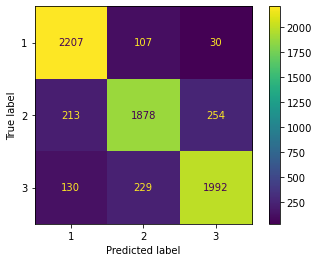

In [32]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
NUM_CLASSES = 3

train_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []

model.eval()

for i, (x, y) in enumerate(train_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	train_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

train_loss = train_loss/len(train_loader.dataset)
print('Train Loss: {:.6f}\n'.format(train_loss))

for i in range(NUM_CLASSES):
    print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
        i, 100.0 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])

cm_display.plot()
plt.show()

# Accuracy = metrics.accuracy_score(actual, predicted)
# Precision = metrics.precision_score(actual, predicted)
# Sensitivity_recall = metrics.recall_score(actual, predicted)
# Specificity = metrics.recall_score(actual, predicted, pos_label=0)
# F1_score = metrics.f1_score(actual, predicted)

# #metrics:
# print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


Test Loss: 0.766537

Test Accuracy of     0: 92% (545/590)
Test Accuracy of     1: 64% (382/588)
Test Accuracy of     2: 76% (446/582)

Test Accuracy (Overall): 78% (1373/1760)


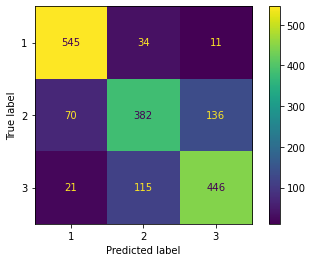

In [33]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

test_loss = 0.0
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))
actual = []
predicted = []
model.eval()

for i, (x, y) in enumerate(test_loader):
	(x, y) = (x.to(device), y.to(torch.float32).to(device))
	output = model(x)
	loss = criterion(output, y)
	test_loss += loss.item() * x.size(0)
	_, pred = torch.max(output, 1)   
	_, y = torch.max(y, 1)
	actual.extend(y)
	predicted.extend(pred)
	correct_tensor = pred.eq(y)
	correct = np.squeeze(correct_tensor)
	for i in range(len(y.data)):
		label = y.data[i]
		class_correct[label] += correct[i].item() 
		class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(NUM_CLASSES):
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            i, 100.0 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
confusion_matrix = metrics.confusion_matrix(actual, predicted)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [1, 2, 3])

cm_display.plot()
plt.show()

# Accuracy = metrics.accuracy_score(actual, predicted)
# Precision = metrics.precision_score(actual, predicted)
# Sensitivity_recall = metrics.recall_score(actual, predicted)
# Specificity = metrics.recall_score(actual, predicted, pos_label=0)
# F1_score = metrics.f1_score(actual, predicted)

# #metrics:
# print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import pandas as pd
import numpy as np

class MLPCWithDropout(nn.Module):
    def __init__(self, input_size):
        super(MLPCWithDropout, self).__init__()
        self.l1 = nn.Linear(input_size, 200)
        self.l2 = nn.Linear(200, 200)
        self.l3 = nn.Linear(200, 200)
        self.dropout3 = nn.Dropout(0.4)
        self.l5 = nn.Linear(200, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        x = F.relu(x)
        x = self.l3(x)
        x = F.relu(x)
        x = self.dropout3(x)
        output = self.l5(x)
        output = self.softmax(output)
        return output

num_cols = 12
model = MLPCWithDropout(num_cols)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

file_path = './voice_mlpc_4L_3D_resampling_CELoss_lr001_500epoch_model.pth'

checkpoint = torch.load(file_path)
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MLPCWithDropout(
  (l1): Linear(in_features=12, out_features=100, bias=True)
  (l2): Linear(in_features=100, out_features=200, bias=True)
  (l3): Linear(in_features=200, out_features=100, bias=True)
  (dropout3): Dropout(p=0.3, inplace=False)
  (l5): Linear(in_features=100, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)